<a href="https://colab.research.google.com/github/greyhound101/internship/blob/master/xception_fold_4_all_145.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Mounted at /content/gdrive


Impoting all necessary packages

In [2]:
import zipfile
import h5py
from keras.optimizers import Adam
import cv2
from keras.utils import to_categorical
import glob, os
from matplotlib import pyplot as plt
import h5py
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm
import time
import gc
from keras.applications import *
from keras.layers import *
from keras import backend as K
from keras.models import Model

Using TensorFlow backend.


Loading the data

In [0]:
path = F"/content/gdrive/My Drive/check.npy" 
df=np.load(path,allow_pickle=True)
df=df.item()

Function to shuffle data in fold and load each fold

In [0]:

#shuffle samples
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]



#change targets
def change(img):
    resized = cv2.resize(img, (299,299), interpolation = cv2.INTER_AREA )
    return resized




#get train and test splits
def get_trn_tst(df,tst_fold):
  idx=np.asarray(df['fold'])
  y=np.asarray(df['label'])
  y-=1
  img=np.asarray(df['image'])
  img1=[]
  for i in range(len(img)):
        img1.append(change(img[i]))
  img1=np.asarray(img1)
  del([img])
  gc.collect()
  trn_y=np.asarray(y[(idx!=tst_fold)])
  trn_img=np.asarray(img1[(idx!=tst_fold)])
  tst_y=np.asarray(y[(idx==tst_fold)])
  tst_img=img1[idx==tst_fold]
  trn_img=np.repeat(trn_img.reshape((trn_img.shape[0],299,299,1)),3,axis=3)
  tst_img=np.repeat(tst_img.reshape((tst_img.shape[0],299,299,1)),3,axis=3)
  return (trn_img.copy(),trn_y.copy()),(tst_img.copy(),tst_y.copy())

Verfying model stricture

In [5]:
mod=Xception(include_top=True, weights='imagenet')
mod.summary()

91889664/91884032 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________

Function to load model

In [0]:
def load_model(last=True):   
  K.clear_session() 
  mod=Xception(include_top=True, weights='imagenet')
  out_1=mod.layers[-2].output
  out=Dense(3,activation='softmax')(out_1)
  model=Model(inputs=mod.input,outputs=out)

  if last:
    for i in range(len(model.layers)):
        model.layers[i].trainable = False
  model.layers[-1].trainable=True
  return model

Loading dictionaries to save data

In [0]:
best_accuracy_last={}
final_accuracy_last={}
history_last={}
answers_last={}
predictions_last={}
predictions_last_best={}
times_last={}

Training all layers

In [0]:


import keras
import pandas as pd
from keras.applications.nasnet import NASNetMobile, preprocess_input
import imgaug as ia
from imgaug import augmenters as iaa

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result
def Hflip( images):
		seq = iaa.Sequential([iaa.Fliplr(1.0)])
		return seq.augment_images(images)
def Vflip( images):
		seq = iaa.Sequential([iaa.Flipud(1.0)])
		return seq.augment_images(images)
def noise(images):
    ls=[]
    for i in images:
        x = np.random.normal(loc=0, scale=0.05, size=(299,299,3))
        ls.append(i+x)
    return ls
def rotate(images):
    ls=[]
    for angle in range(-15,20,5):
        for image in images:
            ls.append(rotate_image(image,angle))
    return ls
class DataGenerator(keras.utils.Sequence):
  def __init__(self, images, labels, batch_size=64, image_dimensions = (96 ,96 ,3), shuffle=False, augment=False):
    self.labels       = labels              # array of labels
    self.images = images        # array of image paths
    self.batch_size   = batch_size          # batch size
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(self.labels.shape[0] / self.batch_size))

  def on_epoch_end(self):
    self.indexes = np.arange(self.labels.shape[0])

  def __getitem__(self, index):
		# selects indices of data for next batch
    indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
    # select data and load images
    labels = self.labels.loc[indexes]
    img = [self.images[k].astype(np.float32) for k in indexes]
    imgH=Hflip(img)
    imgV=Vflip(img)
    imgR=rotate(img)
    images=[]
    images.extend(imgH)
    images.extend(imgV)
    images.extend(imgR)
    lbl=labels.copy()
    labels=pd.DataFrame()
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    del([img,imgH,imgV,imgR])
    gc.collect()
    #images = np.array([preprocess_input(img) for img in images])
    return np.asarray(images), labels


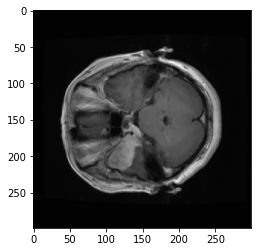

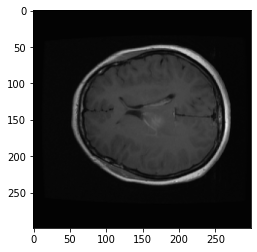

Epoch 1/1
609/609 [==============================] - 705s 1s/step - loss: 0.3517 - accuracy: 0.8776
Epoch 1/1
609/609 [==============================] - 687s 1s/step - loss: 0.0878 - accuracy: 0.9737
Epoch 1/1
609/609 [==============================] - 687s 1s/step - loss: 0.0247 - accuracy: 0.9928
Epoch 1/1
609/609 [==============================] - 687s 1s/step - loss: 0.0058 - accuracy: 0.9984
Epoch 1/1
609/609 [==============================] - 686s 1s/step - loss: 9.5394e-04 - accuracy: 0.9999
Epoch 1/1
609/609 [==============================] - 687s 1s/step - loss: 4.0490e-04 - accuracy: 1.0000
Epoch 1/1
609/609 [==============================] - 687s 1s/step - loss: 2.8775e-04 - accuracy: 1.0000
Epoch 1/1
609/609 [==============================] - 687s 1s/step - loss: 2.1962e-04 - accuracy: 1.0000
Epoch 1/1
609/609 [==============================] - 687s 1s/step - loss: 1.7320e-04 - accuracy: 1.0000
Epoch 1/1
609/609 [==============================] - 687s 1s/step - loss: 1.3922

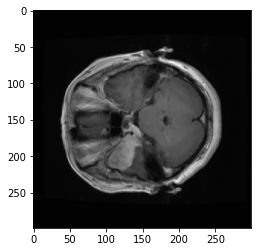

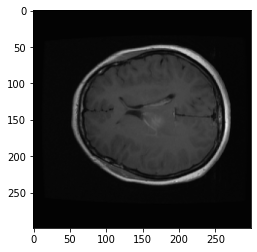

Epoch 1/1
609/609 [==============================] - 705s 1s/step - loss: 0.3517 - accuracy: 0.8776
Epoch 1/1
609/609 [==============================] - 687s 1s/step - loss: 0.0878 - accuracy: 0.9737
Epoch 1/1
609/609 [==============================] - 687s 1s/step - loss: 0.0247 - accuracy: 0.9928
Epoch 1/1
609/609 [==============================] - 687s 1s/step - loss: 0.0058 - accuracy: 0.9984
Epoch 1/1
609/609 [==============================] - 686s 1s/step - loss: 9.5394e-04 - accuracy: 0.9999
Epoch 1/1
609/609 [==============================] - 687s 1s/step - loss: 4.0490e-04 - accuracy: 1.0000
Epoch 1/1
609/609 [==============================] - 687s 1s/step - loss: 2.8775e-04 - accuracy: 1.0000
Epoch 1/1
609/609 [==============================] - 687s 1s/step - loss: 2.1962e-04 - accuracy: 1.0000
Epoch 1/1
609/609 [==============================] - 687s 1s/step - loss: 1.7320e-04 - accuracy: 1.0000
Epoch 1/1
609/609 [==============================] - 687s 1s/step - loss: 1.3922

29

29

In [9]:
  def upd(dk,data):
    if dk==0:
        dk=data
    else:
        for ky in data.keys():
            dk[ky].extend(data[ky])
    return dk
  index=4
  epoch=50
  pre_acc=0
  best=0
  fold='fold_'+str(index)
  trn,tst=get_trn_tst(df,index)
  history_last[fold]=0



  plt.imshow(trn[0][0])
  plt.show()
  plt.imshow(tst[0][0])
  plt.show()



  trn_x,trn_y=unison_shuffled_copies(trn[0],trn[1])
  tst_x,tst_y=unison_shuffled_copies(tst[0],tst[1])



  model=load_model(last=False)


  
  #compiling the model
  model.compile(optimizer=Adam(3e-4,decay=1e-3), 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])
  train_data = DataGenerator(trn_x,pd.get_dummies(trn_y), batch_size=4, augment=True)
  ln=len(trn_y)
  del([trn_x,trn_y,trn,tst])
  gc.collect()
  #fitting the model
  #timing
  start=time.time()
  for i in range(epoch):
      hist=model.fit_generator(train_data,epochs=1,steps_per_epoch=ln//4)
      history_last[fold]=upd(history_last[fold],hist.history)

  end=time.time()
  times_last[fold]=end-start

  #getting the prediction 
  pre=model.predict(tst_x)
  



  #select the maximum position
  pre=np.argmax(pre,1)
  predictions_last[fold]=pre

  
  
  
  #getting the accuracy
  new_acc=accuracy_score(pre,tst_y)

  


  #storing the predictions
  final_accuracy_last[fold]=new_acc








  #storing the answers
  answers_last[fold]=tst_y
    
    
    
    
  #freeing memory
  del([tst_x,tst_y])
  gc.collect()


In [0]:
index=str(index)
type='decay_145'
model='xception'
path = F"/content/gdrive/My Drive/"+model 
np.save(path+"/best_accuracy_all_fold_"+index+"_"+model+"_"+type+".npy",best_accuracy_last)
np.save(path+'/final_accuracy_all_fold'+index+"_"+model+"_"+type+".npy",final_accuracy_last)
np.save(path+'/history_all_fold_'+index+"_"+model+"_"+type+".npy",history_last)
np.save(path+'/answers_all_fold_'+index+"_"+model+"_"+type+".npy",answers_last)
np.save(path+'/predictions_all_fold_'+index+"_"+model+"_"+type+".npy",predictions_last)
np.save(path+'/predictions_all_best_fold_'+index+"_"+model+"_"+type+".npy",predictions_last_best)
np.save(path+'/times_all_fold_'+index+"_"+model+"_"+type+".npy",times_last)

In [12]:
new_acc

0.9697452229299363

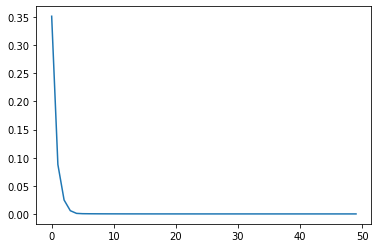

In [13]:
plt.plot(history_last[fold]['loss'])